https://docs.pytorch.org/audio/stable/tutorials/forced_alignment_tutorial.html

In [31]:
from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor
import torchaudio
import librosa
import torch
from dataclasses import dataclass
import matplotlib.pyplot as plt
import os
import soundfile as sf

In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [33]:
model_path = "/data/selinawisco/spring/0421_baseline_44"
model = Wav2Vec2ForCTC.from_pretrained(model_path).eval()
processor = Wav2Vec2Processor.from_pretrained(model_path)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [34]:
# align 할 샘플 음성 
audio_path = "/data/selinawisco/kochild/APAC/일반아동/일반_clear/1_594_2_10_10_0_APAC/1_594_2_10_10_0_APAC_11.wav"
# audio_path = "/data/selinawisco/kochild/APAC/일반아동/일반_clear/1_205_1_9_10_0_APAC/1_205_1_9_10_0_APAC_21.wav"
# audio_path = "/data/selinawisco/kochild/APAC/일반아동/일반_clear/1_326_2_9_10_0_APAC/1_326_2_9_10_0_APAC_33.wav"
# audio_path = "/data/selinawisco/kochild/APAC_25_word/TD/boys/4세/1_278_1_6_9_0_APAC_37_사자.wav"

In [35]:
audio, sampling_rate = librosa.load(audio_path, sr=16000)
    
input_values = processor(audio, sampling_rate=16000, return_tensors="pt").input_values.to(device)


In [36]:
vocab_dict = processor.tokenizer.get_vocab()  # {token: id}
id_to_token = {v: k for k, v in vocab_dict.items()}
# sorted(vocab_dict.keys())

In [37]:
transcript = list("ㅅㅐㄱㅈㅗㅇㅇㅣ")
# transcript = list("ㅅㅏㅈㅏ")
tokens = [vocab_dict[c] for c in transcript if c in vocab_dict]

list(zip(transcript, tokens))

[('ㅅ', 13),
 ('ㅐ', 6),
 ('ㄱ', 41),
 ('ㅈ', 0),
 ('ㅗ', 39),
 ('ㅇ', 36),
 ('ㅇ', 36),
 ('ㅣ', 28)]

In [38]:
with torch.no_grad():
    inputs = processor(input_values.squeeze(), return_tensors="pt", sampling_rate=16000)
    logits = model(**inputs).logits
    # emissions = torch.log_softmax(logits, dim=-1)[0]
    emissions = torch.log_softmax(logits / 1.5, dim=-1)[0]
emissions.shape # timesteps, vocab_size

torch.Size([45, 46])

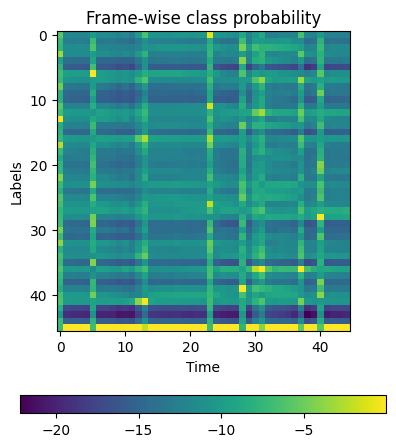

In [39]:
def plot():
    fig, ax = plt.subplots()
    img = ax.imshow(emissions.T)
    ax.set_title("Frame-wise class probability")
    ax.set_xlabel("Time")
    ax.set_ylabel("Labels")
    fig.colorbar(img, ax=ax, shrink=0.6, location="bottom")
    fig.tight_layout()


plot()

In [40]:
def get_trellis(emission, tokens, blank_id=0):
    num_frame = emission.size(0)
    num_tokens = len(tokens)

    trellis = torch.zeros((num_frame, num_tokens))
    trellis[1:, 0] = torch.cumsum(emission[1:, blank_id], 0)
    trellis[0, 1:] = -float("inf")
    trellis[-num_tokens + 1 :, 0] = float("inf")

    for t in range(num_frame - 1):
        trellis[t + 1, 1:] = torch.maximum(
            # Score for staying at the same token
            trellis[t, 1:] + emission[t, blank_id],
            # Score for changing to the next token
            trellis[t, :-1] + emission[t, tokens[1:]],
        )
    return trellis


trellis = get_trellis(emissions, tokens)
trellis

tensor([[   0.0000,      -inf,      -inf,      -inf,      -inf,      -inf,
              -inf,      -inf],
        [ -11.8814,   -6.8565,      -inf,      -inf,      -inf,      -inf,
              -inf,      -inf],
        [ -23.8084,  -18.7380,  -16.8828,      -inf,      -inf,      -inf,
              -inf,      -inf],
        [ -35.7566,  -30.6649,  -28.8098,  -28.8098,      -inf,      -inf,
              -inf,      -inf],
        [ -47.5886,  -42.6132,  -40.7580,  -40.7580,  -41.0406,      -inf,
              -inf,      -inf],
        [ -57.6394,  -54.4452,  -52.5900,  -52.5900,  -52.8726,  -51.3388,
              -inf,      -inf],
        [ -69.1273,  -57.7131,  -62.6408,  -62.6408,  -60.1915,  -61.3896,
          -63.0061,      -inf],
        [ -80.4972,  -69.2009,  -67.5622,  -74.1286,  -71.6794,  -69.6406,
          -70.8386,  -75.1676],
        [ -92.1680,  -80.5709,  -78.9322,  -78.9322,  -83.0493,  -81.0106,
          -79.1133,  -82.9819],
        [-104.3175,  -92.2416,  -90.4

In [41]:
@dataclass
class Point:
    token_index: int
    time_index: int
    score: float


def backtrack(trellis, emission, tokens, blank_id=0):
    t, j = trellis.size(0) - 1, trellis.size(1) - 1

    path = [Point(j, t, emission[t, blank_id].exp().item())]
    while j > 0:
        # Should not happen but just in case
        assert t > 0

        # 1. Figure out if the current position was stay or change
        # Frame-wise score of stay vs change
        p_stay = emission[t - 1, blank_id]
        p_change = emission[t - 1, tokens[j]]

        # Context-aware score for stay vs change
        stayed = trellis[t - 1, j] + p_stay
        changed = trellis[t - 1, j - 1] + p_change

        # Update position
        t -= 1
        if changed > stayed:
            j -= 1

        # Store the path with frame-wise probability.
        prob = (p_change if changed > stayed else p_stay).exp().item()
        path.append(Point(j, t, prob))

    # Now j == 0, which means, it reached the SoS.
    # Fill up the rest for the sake of visualization
    while t > 0:
        prob = emission[t - 1, blank_id].exp().item()
        path.append(Point(j, t - 1, prob))
        t -= 1

    return path[::-1]


path = backtrack(trellis, emissions, tokens)
for p in path:
    print(p)

Point(token_index=0, time_index=0, score=0.0034628305584192276)
Point(token_index=0, time_index=1, score=6.917603968759067e-06)
Point(token_index=0, time_index=2, score=6.609755928366212e-06)
Point(token_index=0, time_index=3, score=6.470689640991623e-06)
Point(token_index=0, time_index=4, score=7.268194622156443e-06)
Point(token_index=0, time_index=5, score=0.9289659261703491)
Point(token_index=1, time_index=6, score=1.0254323569824919e-05)
Point(token_index=1, time_index=7, score=1.1536571037140675e-05)
Point(token_index=1, time_index=8, score=8.54030076880008e-06)
Point(token_index=1, time_index=9, score=5.291033176035853e-06)
Point(token_index=1, time_index=10, score=8.116086064546835e-06)
Point(token_index=1, time_index=11, score=2.5314511731266975e-06)
Point(token_index=1, time_index=12, score=5.0837217713706195e-05)
Point(token_index=1, time_index=13, score=0.7838906645774841)
Point(token_index=2, time_index=14, score=3.0198316380847245e-05)
Point(token_index=3, time_index=15, s

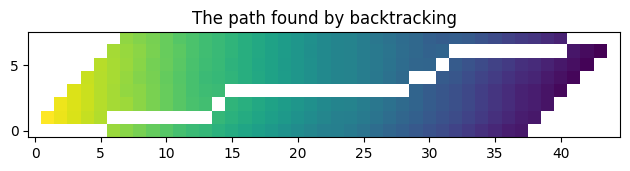

In [42]:
def plot_trellis_with_path(trellis, path):
    # To plot trellis with path, we take advantage of 'nan' value
    trellis_with_path = trellis.clone()
    for _, p in enumerate(path):
        trellis_with_path[p.time_index, p.token_index] = float("nan")
    plt.imshow(trellis_with_path.T, origin="lower")
    plt.title("The path found by backtracking")
    plt.tight_layout()


plot_trellis_with_path(trellis, path)

In [43]:
# Merge the labels
@dataclass
class Segment:
    label: str
    start: int
    end: int
    score: float

    def __repr__(self):
        return f"{self.label}\t({self.score:4.2f}): [{self.start:5d}, {self.end:5d})"

    @property
    def length(self):
        return self.end - self.start


def merge_repeats(path):
    i1, i2 = 0, 0
    segments = []
    while i1 < len(path):
        while i2 < len(path) and path[i1].token_index == path[i2].token_index:
            i2 += 1
        score = sum(path[k].score for k in range(i1, i2)) / (i2 - i1)
        segments.append(
            Segment(
                transcript[path[i1].token_index],
                path[i1].time_index,
                path[i2 - 1].time_index + 1,
                score,
            )
        )
        i1 = i2
    return segments


segments = merge_repeats(path)
for seg in segments:
    print(seg)

ㅅ	(0.16): [    0,     6)
ㅐ	(0.10): [    6,    14)
ㄱ	(0.00): [   14,    15)
ㅈ	(0.10): [   15,    29)
ㅗ	(0.05): [   29,    31)
ㅇ	(0.89): [   31,    32)
ㅇ	(0.10): [   32,    41)
ㅣ	(0.00): [   41,    45)


In [44]:
def frame_to_sample(frame_idx, total_frames, total_samples):
    return int((frame_idx / total_frames) * total_samples)

In [45]:

# Make sure audio is a 1D NumPy array or 1-channel Torch tensor
if isinstance(audio, torch.Tensor):
    audio_np = audio.squeeze().cpu().numpy()
else:
    audio_np = audio

# Set up output directory
output_dir = f"segments/{transcript}"
os.makedirs(output_dir, exist_ok=True)

total_frames = emissions.shape[1] if emissions.ndim == 3 else emissions.shape[0]
total_samples = len(audio_np)

for idx, seg in enumerate(segments):
    start_sample = frame_to_sample(seg.start, total_frames, total_samples)
    end_sample = frame_to_sample(seg.end, total_frames, total_samples)

    segment_audio = audio_np[start_sample:end_sample]
    filename = f"{output_dir}/{seg.label}_{idx}_{seg.start}_{seg.end}.wav"
    sf.write(filename, segment_audio, 16000)

/tmp/ipykernel_3364594/3139461363.py:38: UserWarning: Glyph 12624 (\N{HANGUL LETTER AE}) missing from current font.
  fig.tight_layout()
/tmp/ipykernel_3364594/3139461363.py:38: UserWarning: Glyph 12593 (\N{HANGUL LETTER KIYEOK}) missing from current font.
  fig.tight_layout()
/tmp/ipykernel_3364594/3139461363.py:38: UserWarning: Glyph 12616 (\N{HANGUL LETTER CIEUC}) missing from current font.
  fig.tight_layout()
/tmp/ipykernel_3364594/3139461363.py:38: UserWarning: Glyph 12631 (\N{HANGUL LETTER O}) missing from current font.
  fig.tight_layout()
/tmp/ipykernel_3364594/3139461363.py:38: UserWarning: Glyph 12615 (\N{HANGUL LETTER IEUNG}) missing from current font.
  fig.tight_layout()
/tmp/ipykernel_3364594/3139461363.py:38: UserWarning: Glyph 12643 (\N{HANGUL LETTER I}) missing from current font.
  fig.tight_layout()
/tmp/ipykernel_3364594/3139461363.py:38: UserWarning: Glyph 12613 (\N{HANGUL LETTER SIOS}) missing from current font.
  fig.tight_layout()
/home/selinawisco/anaconda3/env

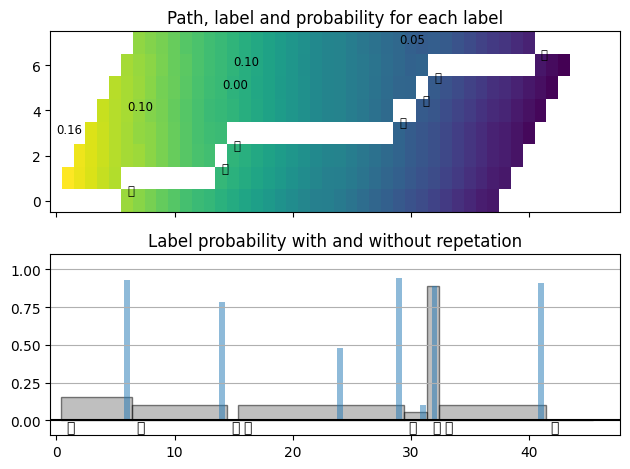

In [46]:
def plot_trellis_with_segments(trellis, segments, transcript):
    # To plot trellis with path, we take advantage of 'nan' value
    trellis_with_path = trellis.clone()
    for i, seg in enumerate(segments):
        if seg.label != "|":
            trellis_with_path[seg.start : seg.end, i] = float("nan")

    fig, [ax1, ax2] = plt.subplots(2, 1, sharex=True)
    ax1.set_title("Path, label and probability for each label")
    ax1.imshow(trellis_with_path.T, origin="lower", aspect="auto")

    for i, seg in enumerate(segments):
        if seg.label != "|":
            ax1.annotate(seg.label, (seg.start, i - 0.7), size="small")
            ax1.annotate(f"{seg.score:.2f}", (seg.start, i + 3), size="small")

    ax2.set_title("Label probability with and without repetation")
    xs, hs, ws = [], [], []
    for seg in segments:
        if seg.label != "|":
            xs.append((seg.end + seg.start) / 2 + 0.4)
            hs.append(seg.score)
            ws.append(seg.end - seg.start)
            ax2.annotate(seg.label, (seg.start + 0.8, -0.07))
    ax2.bar(xs, hs, width=ws, color="gray", alpha=0.5, edgecolor="black")

    xs, hs = [], []
    for p in path:
        label = transcript[p.token_index]
        if label != "|":
            xs.append(p.time_index + 1)
            hs.append(p.score)

    ax2.bar(xs, hs, width=0.5, alpha=0.5)
    ax2.axhline(0, color="black")
    ax2.grid(True, axis="y")
    ax2.set_ylim(-0.1, 1.1)
    fig.tight_layout()


plot_trellis_with_segments(trellis, segments, transcript)